In [ ]:
!gdown 1M3Jf3QoxTVy8lDZ4Xb3d9gABu7xPew5A
!unzip chest_xray.zip

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/chest_xray'
batch_size = 32
image_size = 224
learning_rate = 5e-4
epochs = 15
class_labels = ['NORMAL', 'PNEUMONIA']

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


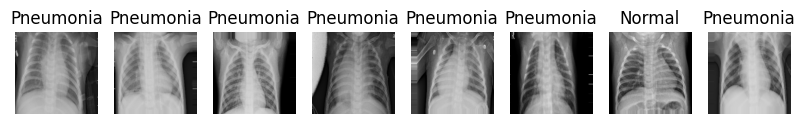

In [ ]:
def show_images(generator, num_images = 5):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title('Normal' if labels[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.show()
show_images(train_generator, num_images=8)

In [ ]:
# model
base_model = tf.keras.applications.ResNet50V2(input_shape=(image_size, image_size, 3),
                                              include_top=False,
                                              weights='imagenet',
                                              pooling='avg')
inputs = base_model.input
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs,outputs)
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

LRS = ReduceLROnPlateau(monitor='val_loss', mode ='min',
                        factor=0.1, patience=3, min_lr=1e-7)
# min_lr LR 감소 한계치
# mode Monitor 가 낮아지는걸 기준으로 ? 아니면 높아지는걸 기준으로 patience?
# factor 몇퍼센트 비율로 LR 감소 시킬지

MC = ModelCheckpoint('checkpoint.tf', monitor='val_loss',
                     mode='min', save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data= validation_generator,
                    callbacks=[LRS,MC,ES])

Epoch 1/15
131/131 [==============================] - 3103s 23s/step - loss: 0.1642 - accuracy: 0.9382 - val_loss: 0.6706 - val_accuracy: 0.8658 - lr: 5.0000e-04
Epoch 2/15
131/131 [==============================] - 3043s 23s/step - loss: 0.1051 - accuracy: 0.9585 - val_loss: 2.6851 - val_accuracy: 0.5101 - lr: 5.0000e-04
Epoch 3/15
131/131 [==============================] - 2842s 22s/step - loss: 0.0942 - accuracy: 0.9665 - val_loss: 0.1032 - val_accuracy: 0.9655 - lr: 5.0000e-04
Epoch 4/15
131/131 [==============================] - 2856s 22s/step - loss: 0.0846 - accuracy: 0.9691 - val_loss: 0.1885 - val_accuracy: 0.9204 - lr: 5.0000e-04
Epoch 5/15
131/131 [==============================] - 2890s 22s/step - loss: 0.0791 - accuracy: 0.9729 - val_loss: 0.2135 - val_accuracy: 0.9032 - lr: 5.0000e-04
Epoch 6/15
131/131 [==============================] - 2880s 22s/step - loss: 0.0567 - accuracy: 0.9813 - val_loss: 0.1406 - val_accuracy: 0.9492 - lr: 5.0000e-04
Epoch 7/15
131/131 [========

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='confusionmatrix'):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('GT')
    plt.xlabel('prediction')

In [ ]:
!mv /content/checkpoint.tf /content/drive/MyDrive/checkpoint.tf

mv: cannot move '/content/checkpoint.tf' to '/content/drive/MyDrive/checkpoint.tf': No such file or directory


In [ ]:
model.load_weights('/content/checkpoint.tf')
prediction = model.predict(test_generator)
predicted_classes = (prediction > 0.5).astype('int').reshape(-1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

20/20 [==============================] - 7s 369ms/step


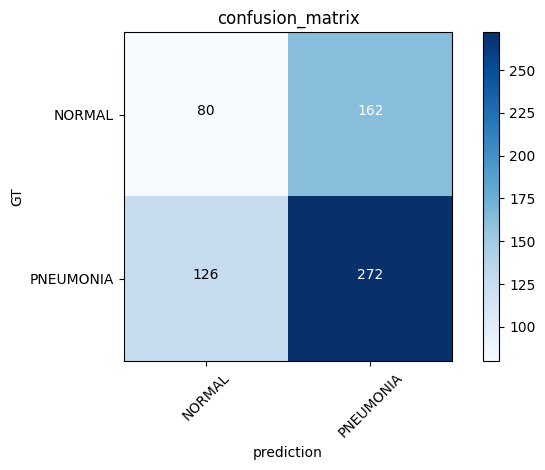

In [ ]:
plot_confusion_matrix(conf_matrix,classes=class_labels, title='confusion_matrix')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes,
                               target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.39      0.33      0.36       242
   PNEUMONIA       0.63      0.68      0.65       398

    accuracy                           0.55       640
   macro avg       0.51      0.51      0.51       640
weighted avg       0.54      0.55      0.54       640



In [ ]:
'''
projfolder
---- model/
------- model.py
------- submodel.py(Multi modal)
------- train.py
------- eval.py

---- data/
-------cv2(resize,convert)
-------norm.py
-------Tokenizing.py(NLP)
-------embedding.py(NLP)

---- utils/
--------NMS.py
--------distance.py
--------IOU.py

---- train.py(option) ->arg.xml
'''

'\nprojfolder\n---- model/\n------- model.py\n------- submodel.py(Multi modal)\n------- train.py\n------- eval.py\n\n---- data/\n-------cv2(resize,convert)\n-------norm.py\n-------Tokenizing.py(NLP)\n-------embedding.py(NLP)\n\n---- utils/\n--------NMS.py\n--------distance.py\n--------IOU.py\n\n---- train.py(option) ->arg.xml\n'

In [ ]:
import matplotlib.cm as cm
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # img_array : predict가 될 이미지 (array 형태로 입력)
  # model : 테스트를 진행할, 학습이 된 모델
  # last_conv_layer_name: grad 시각화를 진행할 레이어 이름
  # pred_index : 히트맵이 생성 될 클래스 인덱스, None 일 경우, 가장 높은 예측 점수를 가진
  # 클래스가 사용 될 예정

    # 모델 구조 변경
    grad_model = tf.keras.models.Model(inputs=[model.inputs], outputs=[model.get_layer(last_conv_layer_name).output,model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, pred = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(pred[0])
        class_channel = pred[ : , pred_index]

    grads =  tape.gradient(class_channel, last_conv_layer_output)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    last_conv_layer_otput = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled[... , tf.newaxis]
    # 행렬곱 @, dotproduct *
    # pooled[... , tf.newaxis] = 벡터를 2D행렬로 변환, 채널의 중요도가 한 열을 이루는 행
    # ex ) [3] 의 벡터가 있다면 [3, 1]
    # 곱셈의 결과는 모든 feature맵에 대해 중요도에 따라 가중치를 곱하여 하나의 히트맵을 생성
    # 히트맵은 어떤 부분이 모델 예측에 가장 큰 영향을 미쳤는지 확인

    heatmap = tf.squeeze(heatmap) # tensor to matrix
    # [높이, 너비, 1] -> [높이, 너비]

    heatmap = tf.maximum(heatmap) # ReLU

    return heatmap.numpy()



In [ ]:
def overlay_heatmap_on_image(heatmap, img):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap('jet')
    jet_color = jet(np.arange(256))[: , :3]
    jet_heatmap = jet_color[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)#
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    tf.keras.preprocessing.image.img_to_array
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)#

    superimposed_img = jet_heatmap * 0.005 + img
    superimposed_img = tf.keras.preprocessing.image.img_to_array(superimposed_img)#
    return superimposed_img


In [ ]:
last_conv_layer_name = 'post_relu'

fig, ax = plt.subplots(4,4, figsize=(12,12))
for i in range(4):
    for j in range(4):
        img, label = test_generator.next()
        img = img[0]
        class_idx = np.argmax(label[0])
        class_name = class_labels[class_idx]
        heatmap = make_gradcam_heatmap(np.array([img]), model, last_conv_layer_name)
        superimposed_img = overlay_heatmap_on_image(heatmap, img)
        ax[i,j].imshow(superimposed_img)
        ax[i,j].set_title(class_name)
        ax[i,j].axis('off')
plt.tight_layout()
plt.show()